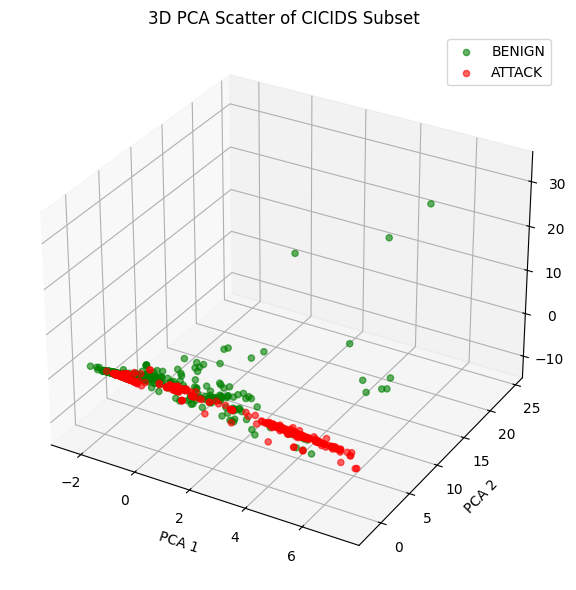

Generating training kernel...


Building Kernel Rows: 100%|██████████| 1200/1200 [1:33:33<00:00,  4.68s/it]


Generating test kernel...


Building Kernel Rows: 100%|██████████| 300/300 [51:03<00:00, 10.21s/it]



Training Report:
              precision    recall  f1-score   support

           0       0.74      0.88      0.81       600
           1       0.85      0.69      0.77       600

    accuracy                           0.79      1200
   macro avg       0.80      0.79      0.79      1200
weighted avg       0.80      0.79      0.79      1200


Test Report:
              precision    recall  f1-score   support

           0       0.73      0.90      0.81       150
           1       0.87      0.67      0.76       150

    accuracy                           0.79       300
   macro avg       0.80      0.79      0.78       300
weighted avg       0.80      0.79      0.78       300

Time taken: 9443.05 seconds


In [1]:
import os
import time
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.manifold import TSNE

import pennylane as qml
from pennylane.templates import AngleEmbedding, BasicEntanglerLayers
from tqdm import tqdm

# Start timing
start_time = time.time()

# Load dataset
df = pd.read_csv("mergedTop20.csv", low_memory=False)
cols = [
    "Bwd Packet Length Std", "Flow Bytes/s", "Total Length of Fwd Packets", "Fwd Packet Length Std",
    "Flow IAT Std", "Flow IAT Min", "Fwd IAT Total", "Flow Duration", "Bwd Packet Length Max",
    "Flow IAT Max", "Flow IAT Mean", "Total Length of Bwd Packets", "Fwd Packet Length Min",
    "Bwd Packet Length Mean", "Flow Packets/s", "Fwd Packet Length Mean", "Total Backward Packets",
    "Fwd Packet Length Max", "Total Fwd Packets", "Bwd Packet Length Min", "Label"
]
df = df[cols].fillna(0)
df["Label"] = df["Label"].apply(lambda x: 1 if x == "BENIGN" else 0)

# Feature Selection
X = df.drop("Label", axis=1)
y = df["Label"]
top_indices = np.argsort(RandomForestClassifier().fit(X, y).feature_importances_)[::-1][:15]
X_top = X.iloc[:, top_indices]

# Balancing
benign = X_top[y == 1].sample(n=750, random_state=42)
attack = X_top[y == 0].sample(n=750, random_state=42)
X_bal = pd.concat([benign, attack]).reset_index(drop=True)
y_bal = pd.Series([1]*750 + [0]*750)

# Scaling & PCA
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_bal)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_scaled)

#to check class separation
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_pca[y_bal == 1][:, 0], X_pca[y_bal == 1][:, 1], X_pca[y_bal == 1][:, 2],
           c='green', label='BENIGN', alpha=0.6)
ax.scatter(X_pca[y_bal == 0][:, 0], X_pca[y_bal == 0][:, 1], X_pca[y_bal == 0][:, 2],
           c='red', label='ATTACK', alpha=0.6)

ax.set_xlabel("PCA 1")
ax.set_ylabel("PCA 2")
ax.set_zlabel("PCA 3")
ax.set_title("3D PCA Scatter of CICIDS Subset")
ax.legend()
plt.tight_layout()
plt.show()

X_train, X_test, y_train, y_test = train_test_split(X_pca, y_bal, test_size=0.2, stratify=y_bal, random_state=42)

# Quantum kernel definition
n_qubits = X_train.shape[1]
dev = qml.device("default.qubit", wires=n_qubits)

def feature_map(x):
    qml.AngleEmbedding(x, wires=range(n_qubits), rotation='Y')
    qml.BasicEntanglerLayers(weights=np.ones((1, n_qubits)), wires=range(n_qubits))

@qml.qnode(dev)
def kernel_circuit(x1, x2):
    feature_map(x1)
    qml.adjoint(feature_map)(x2)
    return qml.probs(wires=range(n_qubits))

def normalize_input(x):
    return np.pi * x / np.max(np.abs(x))

def fidelity(x1, x2):
    x1 = normalize_input(x1)
    x2 = normalize_input(x2)
    return kernel_circuit(x1, x2)[0]

def create_kernel_matrix(X1, X2):
    kernel = np.zeros((len(X1), len(X2)))
    for i in tqdm(range(len(X1)), desc="Building Kernel Rows"):
        for j in range(len(X2)):
            kernel[i, j] = fidelity(X1[i], X2[j])
    return kernel

# Compute kernel matrices
print("Generating training kernel...")
kernel_train = create_kernel_matrix(X_train, X_train)

print("Generating test kernel...")
kernel_test = create_kernel_matrix(X_test, X_train)

# Train SVM
clf = SVC(kernel="precomputed")
clf.fit(kernel_train, y_train)

# Predict and evaluate
y_pred_train = clf.predict(kernel_train)
y_pred_test = clf.predict(kernel_test)

print("\nTraining Report:")
print(classification_report(y_train, y_pred_train))

print("\nTest Report:")
print(classification_report(y_test, y_pred_test))

# Save results
os.makedirs("Pennylane_Result_3", exist_ok=True)
joblib.dump(clf, "Pennylane_Result_3/pennylane_qsvc.pkl", compress=3)
joblib.dump(scaler, "Pennylane_Result_3/pennylane_scaler.pkl", compress=3)
joblib.dump(pca, "Pennylane_Result_3/pennylane_pca.pkl", compress=3)
joblib.dump(cols[:-1], "Pennylane_Result_3/pennylane_features_used.pkl", compress=3)

print("Time taken:", round(time.time() - start_time, 2), "seconds")